# Redes Neuronales para la clasificación de puntos 

Inicialmente importamos la librería que utilizaremos:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from keras.models import Sequential
from keras.layers import Dense

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


### Simulación de datos:

In [2]:
def centros_asociados_a_cada_color(color, kcentros):
   
    centro = np.array([0,0])
    covarianza = np.identity(2)
    
    if color == 0: #azul
        centro = np.array([1,0])
    
    if color == 1: #rojo
        centro = np.array([0,1])

    lista_de_centros = np.random.multivariate_normal(centro,covarianza,kcentros).T
        
    return lista_de_centros

In [3]:
centros_azul = centros_asociados_a_cada_color(0,10)
centros_rojo = centros_asociados_a_cada_color(1,10)

In [4]:
def visualize_colors(ptos_azul, ptos_rojo):

    x1azul = ptos_azul[0]
    x2azul = ptos_azul[1]
    
    x1rojo = ptos_rojo[0]
    x2rojo = ptos_rojo[1]
    
    plt.plot(x1azul,x2azul,"bo")
    plt.plot(x1rojo,x2rojo,"ro")
    plt.axis([-4,4,-4,4])
    plt.title("Distribucion de puntos segun el color")
    plt.show() 

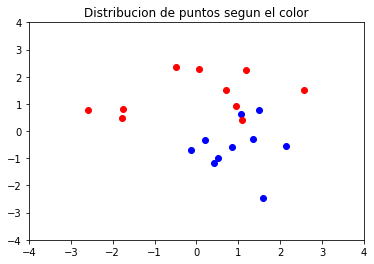

In [5]:
visualize_colors(centros_azul, centros_rojo)

In [6]:
def Simulacion(centros, N):
    
    Ncentros = centros.shape[1]
    
    #Inicializamos la lista de observaciones 
    observations = np.zeros((2,N))
    
    #Definimos un valor global para la covarianza
    covarianza = np.identity(2)/5
       
    #hacemos un loop entre 0 y N para generar todos las observaciones requeridas
    
    for obs in range(0,N):
        #generamos un numero aleatorio entre los números 0 y Ncentros-1 para escoger el centro de nuestra gaussiana bivariada
        indice_del_centro = random.randint(0, Ncentros-1)
        
        xcentro = centros[0,indice_del_centro]
        ycentro = centros[1,indice_del_centro]
        
        mk_centro = np.array([xcentro, ycentro])
        
        centro_aux = np.random.multivariate_normal(mk_centro,covarianza,1).T
    
        observations[0,obs] = centro_aux[0,0]
        observations[1,obs] = centro_aux[1,0]
    
    return observations

In [7]:
ptos_observados_azul_train =  Simulacion(centros_azul, 1000)
ptos_observados_rojo_train =  Simulacion(centros_rojo, 1000)

In [8]:
ptos_observados_azul_valid =  Simulacion(centros_azul, 200)
ptos_observados_rojo_valid =  Simulacion(centros_rojo, 200)

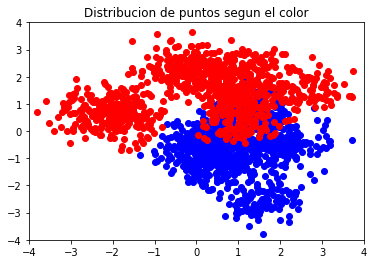

In [9]:
visualize_colors(ptos_observados_azul_train, ptos_observados_rojo_train)

In [10]:
ptos_observados_azul_test =  Simulacion(centros_azul, 5000)
ptos_observados_rojo_test =  Simulacion(centros_rojo, 5000)

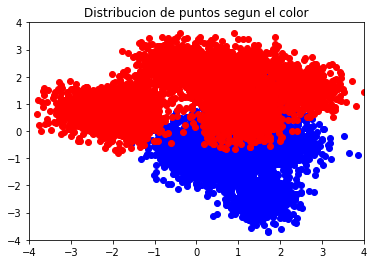

In [11]:
visualize_colors(ptos_observados_azul_test, ptos_observados_rojo_test)

In [12]:
x1azul_train = ptos_observados_azul_train[0,:]
x2azul_train = ptos_observados_azul_train[1,:]

x1rojo_train = ptos_observados_rojo_train[0,:]
x2rojo_train = ptos_observados_rojo_train[1,:]

x1azul_valid = ptos_observados_azul_valid[0,:]
x2azul_valid = ptos_observados_azul_valid[1,:]

x1rojo_valid = ptos_observados_rojo_valid[0,:]
x2rojo_valid = ptos_observados_rojo_valid[1,:]

x1azul_test = ptos_observados_azul_test[0,:]
x2azul_test = ptos_observados_azul_test[1,:]

x1rojo_test = ptos_observados_rojo_test[0,:]
x2rojo_test = ptos_observados_rojo_test[1,:]

Formación de las matrices X, X_test y los vectores de output:

In [13]:
X_train = []
y_train = [] 

for i in range(len(x1azul_train)):
    X_train.append([x1azul_train[i],x2azul_train[i]])
    y_train.append(0)

for i in range(len(x1rojo_train)):
    X_train.append([x1rojo_train[i],x2rojo_train[i]])
    y_train.append(1)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [14]:
X_valid = []
y_valid = [] 

for i in range(len(x1azul_valid)):
    X_valid.append([x1azul_valid[i],x2azul_valid[i]])
    y_valid.append(0)

for i in range(len(x1rojo_valid)):
    X_valid.append([x1rojo_valid[i],x2rojo_valid[i]])
    y_valid.append(1)

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

In [15]:
X_test = []
y_test = [] 

for i in range(len(x1azul_test)):
    X_test.append([x1azul_test[i],x2azul_test[i]])
    y_test.append(0)

for i in range(len(x1rojo_test)):
    X_test.append([x1rojo_test[i],x2rojo_test[i]])
    y_test.append(1)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape , y_test.shape

((2000, 2), (2000,), (400, 2), (400,), (10000, 2), (10000,))

## Contrucción de Red Neuronal

Añadiremos una capa a la vez, las que seguirán las siguientes características:

- El modelo esperará filas de los datos con 2 variables, por lo que el argumento input_dim=2.
- La primera capa oculta tendrá 2 nodos o neuronas (al parecer el bias no se considera), lo que obtenemos al escribir un 2 en la primera variable de entrada de  Dense y tendrá una función de activación sigmoid, ya que de esta forma lo resolvimos en el resumen.
- La capa de salida tendrá solo una neurona y también usará una función de activación sigmoid.

In [17]:
#Definición del modelo utilizando Keras
#model = Sequential()
#model.add(Dense(2, input_dim=2, activation='sigmoid'))
#model.add(Dense(1, activation='sigmoid'))

model_file = "dense1.h5"

inputs = Input(shape=(2,))

x = Dense(2)(inputs)
x = Activation("sigmoid")(x)

x = Dense(1)(x)
x = Activation("sigmoid")(x)
    
model = Model(inputs, x)

# Compilación del modelo:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [18]:
callbacks = [
        EarlyStopping(patience=20, verbose=1),
        ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
        ModelCheckpoint(model_file, verbose=1, save_best_only=True, save_weights_only=True)]
    
results = model.fit(X_train, y_train, batch_size=10, shuffle='batch', epochs=1000, callbacks=callbacks, \
                    validation_data=(X_valid, y_valid))

Train on 2000 samples, validate on 400 samples
Epoch 1/1000
2000/2000 [==============================] - 1s 437us/step - loss: 0.6178 - accuracy: 0.5545 - val_loss: 0.6078 - val_accuracy: 0.5825

Epoch 00001: val_loss improved from inf to 0.60782, saving model to dense1.h5
Epoch 2/1000
2000/2000 [==============================] - 1s 323us/step - loss: 0.5809 - accuracy: 0.6715 - val_loss: 0.5751 - val_accuracy: 0.7075

Epoch 00002: val_loss improved from 0.60782 to 0.57511, saving model to dense1.h5
Epoch 3/1000
2000/2000 [==============================] - 1s 331us/step - loss: 0.5485 - accuracy: 0.7785 - val_loss: 0.5462 - val_accuracy: 0.7950

Epoch 00003: val_loss improved from 0.57511 to 0.54619, saving model to dense1.h5
Epoch 4/1000
2000/2000 [==============================] - 1s 332us/step - loss: 0.5205 - accuracy: 0.8315 - val_loss: 0.5201 - val_accuracy: 0.8475

Epoch 00004: val_loss improved from 0.54619 to 0.52015, saving model to dense1.h5
Epoch 5/1000
2000/2000 [=========

2000/2000 [==============================] - 1s 338us/step - loss: 0.2844 - accuracy: 0.8855 - val_loss: 0.3004 - val_accuracy: 0.8775

Epoch 00036: val_loss improved from 0.30135 to 0.30037, saving model to dense1.h5
Epoch 37/1000
2000/2000 [==============================] - 1s 358us/step - loss: 0.2835 - accuracy: 0.8850 - val_loss: 0.2995 - val_accuracy: 0.8775

Epoch 00037: val_loss improved from 0.30037 to 0.29949, saving model to dense1.h5
Epoch 38/1000
2000/2000 [==============================] - 1s 422us/step - loss: 0.2826 - accuracy: 0.8850 - val_loss: 0.2987 - val_accuracy: 0.8775

Epoch 00038: val_loss improved from 0.29949 to 0.29869, saving model to dense1.h5
Epoch 39/1000
2000/2000 [==============================] - 1s 294us/step - loss: 0.2819 - accuracy: 0.8850 - val_loss: 0.2980 - val_accuracy: 0.8775

Epoch 00039: val_loss improved from 0.29869 to 0.29796, saving model to dense1.h5
Epoch 40/1000
2000/2000 [==============================] - 1s 279us/step - loss: 0.281

2000/2000 [==============================] - 1s 298us/step - loss: 0.2717 - accuracy: 0.8850 - val_loss: 0.2887 - val_accuracy: 0.8800

Epoch 00071: val_loss improved from 0.28884 to 0.28872, saving model to dense1.h5
Epoch 72/1000
2000/2000 [==============================] - 1s 284us/step - loss: 0.2714 - accuracy: 0.8860 - val_loss: 0.2886 - val_accuracy: 0.8800

Epoch 00072: val_loss improved from 0.28872 to 0.28859, saving model to dense1.h5
Epoch 73/1000
2000/2000 [==============================] - 1s 279us/step - loss: 0.2712 - accuracy: 0.8855 - val_loss: 0.2885 - val_accuracy: 0.8800

Epoch 00073: val_loss improved from 0.28859 to 0.28846, saving model to dense1.h5
Epoch 74/1000
2000/2000 [==============================] - 1s 281us/step - loss: 0.2712 - accuracy: 0.8855 - val_loss: 0.2883 - val_accuracy: 0.8800

Epoch 00074: val_loss improved from 0.28846 to 0.28834, saving model to dense1.h5
Epoch 75/1000
2000/2000 [==============================] - 1s 281us/step - loss: 0.270

2000/2000 [==============================] - 1s 314us/step - loss: 0.2664 - accuracy: 0.8855 - val_loss: 0.2844 - val_accuracy: 0.8800

Epoch 00106: val_loss improved from 0.28454 to 0.28439, saving model to dense1.h5
Epoch 107/1000
2000/2000 [==============================] - 1s 285us/step - loss: 0.2662 - accuracy: 0.8840 - val_loss: 0.2843 - val_accuracy: 0.8800

Epoch 00107: val_loss improved from 0.28439 to 0.28427, saving model to dense1.h5
Epoch 108/1000
2000/2000 [==============================] - 1s 299us/step - loss: 0.2664 - accuracy: 0.8855 - val_loss: 0.2841 - val_accuracy: 0.8800

Epoch 00108: val_loss improved from 0.28427 to 0.28410, saving model to dense1.h5
Epoch 109/1000
2000/2000 [==============================] - 1s 286us/step - loss: 0.2662 - accuracy: 0.8855 - val_loss: 0.2840 - val_accuracy: 0.8800

Epoch 00109: val_loss improved from 0.28410 to 0.28395, saving model to dense1.h5
Epoch 110/1000
2000/2000 [==============================] - 1s 287us/step - loss: 0

2000/2000 [==============================] - 1s 315us/step - loss: 0.2607 - accuracy: 0.8835 - val_loss: 0.2784 - val_accuracy: 0.8800

Epoch 00141: val_loss improved from 0.27860 to 0.27838, saving model to dense1.h5
Epoch 142/1000
2000/2000 [==============================] - 1s 318us/step - loss: 0.2605 - accuracy: 0.8845 - val_loss: 0.2782 - val_accuracy: 0.8800

Epoch 00142: val_loss improved from 0.27838 to 0.27819, saving model to dense1.h5
Epoch 143/1000
2000/2000 [==============================] - 1s 299us/step - loss: 0.2603 - accuracy: 0.8850 - val_loss: 0.2780 - val_accuracy: 0.8800

Epoch 00143: val_loss improved from 0.27819 to 0.27801, saving model to dense1.h5
Epoch 144/1000
2000/2000 [==============================] - 1s 305us/step - loss: 0.2600 - accuracy: 0.8840 - val_loss: 0.2778 - val_accuracy: 0.8800

Epoch 00144: val_loss improved from 0.27801 to 0.27783, saving model to dense1.h5
Epoch 145/1000
2000/2000 [==============================] - 1s 296us/step - loss: 0

2000/2000 [==============================] - 1s 309us/step - loss: 0.2556 - accuracy: 0.8835 - val_loss: 0.2725 - val_accuracy: 0.8800

Epoch 00176: val_loss improved from 0.27265 to 0.27249, saving model to dense1.h5
Epoch 177/1000
2000/2000 [==============================] - 1s 318us/step - loss: 0.2552 - accuracy: 0.8830 - val_loss: 0.2724 - val_accuracy: 0.8825

Epoch 00177: val_loss improved from 0.27249 to 0.27238, saving model to dense1.h5
Epoch 178/1000
2000/2000 [==============================] - 1s 322us/step - loss: 0.2553 - accuracy: 0.8835 - val_loss: 0.2722 - val_accuracy: 0.8800

Epoch 00178: val_loss improved from 0.27238 to 0.27219, saving model to dense1.h5
Epoch 179/1000
2000/2000 [==============================] - 1s 310us/step - loss: 0.2551 - accuracy: 0.8830 - val_loss: 0.2721 - val_accuracy: 0.8800

Epoch 00179: val_loss improved from 0.27219 to 0.27206, saving model to dense1.h5
Epoch 180/1000
2000/2000 [==============================] - 1s 297us/step - loss: 0

2000/2000 [==============================] - 1s 394us/step - loss: 0.2516 - accuracy: 0.8835 - val_loss: 0.2680 - val_accuracy: 0.8800

Epoch 00211: val_loss improved from 0.26813 to 0.26800, saving model to dense1.h5
Epoch 212/1000
2000/2000 [==============================] - 1s 345us/step - loss: 0.2513 - accuracy: 0.8835 - val_loss: 0.2679 - val_accuracy: 0.8800

Epoch 00212: val_loss improved from 0.26800 to 0.26790, saving model to dense1.h5
Epoch 213/1000
2000/2000 [==============================] - 1s 404us/step - loss: 0.2512 - accuracy: 0.8845 - val_loss: 0.2678 - val_accuracy: 0.8800

Epoch 00213: val_loss improved from 0.26790 to 0.26779, saving model to dense1.h5
Epoch 214/1000
2000/2000 [==============================] - 1s 422us/step - loss: 0.2511 - accuracy: 0.8835 - val_loss: 0.2677 - val_accuracy: 0.8800

Epoch 00214: val_loss improved from 0.26779 to 0.26767, saving model to dense1.h5
Epoch 215/1000
2000/2000 [==============================] - 1s 359us/step - loss: 0

2000/2000 [==============================] - 1s 287us/step - loss: 0.2482 - accuracy: 0.8845 - val_loss: 0.2646 - val_accuracy: 0.8775

Epoch 00246: val_loss improved from 0.26464 to 0.26458, saving model to dense1.h5
Epoch 247/1000
2000/2000 [==============================] - 1s 291us/step - loss: 0.2482 - accuracy: 0.8855 - val_loss: 0.2645 - val_accuracy: 0.8775

Epoch 00247: val_loss improved from 0.26458 to 0.26449, saving model to dense1.h5
Epoch 248/1000
2000/2000 [==============================] - 1s 320us/step - loss: 0.2481 - accuracy: 0.8855 - val_loss: 0.2644 - val_accuracy: 0.8775

Epoch 00248: val_loss improved from 0.26449 to 0.26440, saving model to dense1.h5
Epoch 249/1000
2000/2000 [==============================] - 1s 364us/step - loss: 0.2481 - accuracy: 0.8850 - val_loss: 0.2643 - val_accuracy: 0.8800

Epoch 00249: val_loss improved from 0.26440 to 0.26430, saving model to dense1.h5
Epoch 250/1000
2000/2000 [==============================] - 1s 327us/step - loss: 0

2000/2000 [==============================] - 1s 351us/step - loss: 0.2454 - accuracy: 0.8885 - val_loss: 0.2617 - val_accuracy: 0.8775

Epoch 00281: val_loss improved from 0.26174 to 0.26166, saving model to dense1.h5
Epoch 282/1000
2000/2000 [==============================] - 1s 353us/step - loss: 0.2455 - accuracy: 0.8890 - val_loss: 0.2616 - val_accuracy: 0.8800

Epoch 00282: val_loss improved from 0.26166 to 0.26157, saving model to dense1.h5
Epoch 283/1000
2000/2000 [==============================] - 1s 397us/step - loss: 0.2453 - accuracy: 0.8890 - val_loss: 0.2615 - val_accuracy: 0.8800

Epoch 00283: val_loss improved from 0.26157 to 0.26151, saving model to dense1.h5
Epoch 284/1000
2000/2000 [==============================] - 1s 368us/step - loss: 0.2453 - accuracy: 0.8875 - val_loss: 0.2614 - val_accuracy: 0.8800

Epoch 00284: val_loss improved from 0.26151 to 0.26143, saving model to dense1.h5
Epoch 285/1000
2000/2000 [==============================] - 1s 331us/step - loss: 0

2000/2000 [==============================] - 1s 337us/step - loss: 0.2430 - accuracy: 0.8890 - val_loss: 0.2590 - val_accuracy: 0.8800

Epoch 00316: val_loss improved from 0.25913 to 0.25904, saving model to dense1.h5
Epoch 317/1000
2000/2000 [==============================] - 1s 317us/step - loss: 0.2429 - accuracy: 0.8890 - val_loss: 0.2589 - val_accuracy: 0.8800

Epoch 00317: val_loss improved from 0.25904 to 0.25895, saving model to dense1.h5
Epoch 318/1000
2000/2000 [==============================] - 1s 341us/step - loss: 0.2429 - accuracy: 0.8895 - val_loss: 0.2589 - val_accuracy: 0.8800

Epoch 00318: val_loss improved from 0.25895 to 0.25891, saving model to dense1.h5
Epoch 319/1000
2000/2000 [==============================] - 1s 305us/step - loss: 0.2429 - accuracy: 0.8895 - val_loss: 0.2588 - val_accuracy: 0.8800

Epoch 00319: val_loss improved from 0.25891 to 0.25880, saving model to dense1.h5
Epoch 320/1000
2000/2000 [==============================] - 1s 398us/step - loss: 0

2000/2000 [==============================] - 1s 294us/step - loss: 0.2406 - accuracy: 0.8895 - val_loss: 0.2566 - val_accuracy: 0.8775

Epoch 00351: val_loss improved from 0.25667 to 0.25659, saving model to dense1.h5
Epoch 352/1000
2000/2000 [==============================] - 1s 289us/step - loss: 0.2406 - accuracy: 0.8895 - val_loss: 0.2565 - val_accuracy: 0.8775

Epoch 00352: val_loss improved from 0.25659 to 0.25653, saving model to dense1.h5
Epoch 353/1000
2000/2000 [==============================] - 1s 297us/step - loss: 0.2405 - accuracy: 0.8895 - val_loss: 0.2565 - val_accuracy: 0.8775

Epoch 00353: val_loss improved from 0.25653 to 0.25646, saving model to dense1.h5
Epoch 354/1000
2000/2000 [==============================] - 1s 293us/step - loss: 0.2404 - accuracy: 0.8895 - val_loss: 0.2564 - val_accuracy: 0.8775

Epoch 00354: val_loss improved from 0.25646 to 0.25639, saving model to dense1.h5
Epoch 355/1000
2000/2000 [==============================] - 1s 299us/step - loss: 0

2000/2000 [==============================] - 1s 341us/step - loss: 0.2385 - accuracy: 0.8930 - val_loss: 0.2544 - val_accuracy: 0.8800

Epoch 00386: val_loss improved from 0.25449 to 0.25437, saving model to dense1.h5
Epoch 387/1000
2000/2000 [==============================] - 1s 292us/step - loss: 0.2382 - accuracy: 0.8930 - val_loss: 0.2544 - val_accuracy: 0.8775

Epoch 00387: val_loss did not improve from 0.25437
Epoch 388/1000
2000/2000 [==============================] - 1s 300us/step - loss: 0.2382 - accuracy: 0.8925 - val_loss: 0.2543 - val_accuracy: 0.8800

Epoch 00388: val_loss improved from 0.25437 to 0.25427, saving model to dense1.h5
Epoch 389/1000
2000/2000 [==============================] - 1s 300us/step - loss: 0.2380 - accuracy: 0.8920 - val_loss: 0.2542 - val_accuracy: 0.8800

Epoch 00389: val_loss improved from 0.25427 to 0.25421, saving model to dense1.h5
Epoch 390/1000
2000/2000 [==============================] - 1s 288us/step - loss: 0.2380 - accuracy: 0.8925 - val_


Epoch 00421: val_loss improved from 0.25259 to 0.25250, saving model to dense1.h5
Epoch 422/1000
2000/2000 [==============================] - 1s 304us/step - loss: 0.2359 - accuracy: 0.8935 - val_loss: 0.2524 - val_accuracy: 0.8775

Epoch 00422: val_loss improved from 0.25250 to 0.25244, saving model to dense1.h5
Epoch 423/1000
2000/2000 [==============================] - 1s 289us/step - loss: 0.2358 - accuracy: 0.8930 - val_loss: 0.2524 - val_accuracy: 0.8775

Epoch 00423: val_loss improved from 0.25244 to 0.25240, saving model to dense1.h5
Epoch 424/1000
2000/2000 [==============================] - 1s 290us/step - loss: 0.2358 - accuracy: 0.8920 - val_loss: 0.2523 - val_accuracy: 0.8775

Epoch 00424: val_loss improved from 0.25240 to 0.25233, saving model to dense1.h5
Epoch 425/1000
2000/2000 [==============================] - 1s 287us/step - loss: 0.2357 - accuracy: 0.8935 - val_loss: 0.2523 - val_accuracy: 0.8775

Epoch 00425: val_loss improved from 0.25233 to 0.25229, saving mode

2000/2000 [==============================] - 1s 395us/step - loss: 0.2340 - accuracy: 0.8930 - val_loss: 0.2509 - val_accuracy: 0.8750

Epoch 00457: val_loss did not improve from 0.25092
Epoch 458/1000
2000/2000 [==============================] - 1s 313us/step - loss: 0.2339 - accuracy: 0.8925 - val_loss: 0.2509 - val_accuracy: 0.8750

Epoch 00458: val_loss improved from 0.25092 to 0.25086, saving model to dense1.h5
Epoch 459/1000
2000/2000 [==============================] - 1s 295us/step - loss: 0.2341 - accuracy: 0.8935 - val_loss: 0.2509 - val_accuracy: 0.8750

Epoch 00459: val_loss did not improve from 0.25086
Epoch 460/1000
2000/2000 [==============================] - 1s 313us/step - loss: 0.2337 - accuracy: 0.8915 - val_loss: 0.2508 - val_accuracy: 0.8750

Epoch 00460: val_loss improved from 0.25086 to 0.25081, saving model to dense1.h5
Epoch 461/1000
2000/2000 [==============================] - 1s 397us/step - loss: 0.2337 - accuracy: 0.8925 - val_loss: 0.2507 - val_accuracy: 0.

2000/2000 [==============================] - 1s 300us/step - loss: 0.2321 - accuracy: 0.8940 - val_loss: 0.2496 - val_accuracy: 0.8750

Epoch 00493: val_loss improved from 0.24967 to 0.24961, saving model to dense1.h5
Epoch 494/1000
2000/2000 [==============================] - 1s 291us/step - loss: 0.2320 - accuracy: 0.8935 - val_loss: 0.2496 - val_accuracy: 0.8750

Epoch 00494: val_loss improved from 0.24961 to 0.24958, saving model to dense1.h5
Epoch 495/1000
2000/2000 [==============================] - 1s 292us/step - loss: 0.2321 - accuracy: 0.8925 - val_loss: 0.2496 - val_accuracy: 0.8750

Epoch 00495: val_loss improved from 0.24958 to 0.24955, saving model to dense1.h5
Epoch 496/1000
2000/2000 [==============================] - 1s 323us/step - loss: 0.2321 - accuracy: 0.8940 - val_loss: 0.2495 - val_accuracy: 0.8750

Epoch 00496: val_loss improved from 0.24955 to 0.24952, saving model to dense1.h5
Epoch 497/1000
2000/2000 [==============================] - 1s 290us/step - loss: 0

2000/2000 [==============================] - 1s 294us/step - loss: 0.2307 - accuracy: 0.8930 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00528: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00528: val_loss improved from 0.24888 to 0.24888, saving model to dense1.h5
Epoch 529/1000
2000/2000 [==============================] - 1s 298us/step - loss: 0.2306 - accuracy: 0.8930 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00529: val_loss improved from 0.24888 to 0.24887, saving model to dense1.h5
Epoch 530/1000
2000/2000 [==============================] - 1s 301us/step - loss: 0.2306 - accuracy: 0.8930 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00530: val_loss improved from 0.24887 to 0.24887, saving model to dense1.h5
Epoch 531/1000
2000/2000 [==============================] - 1s 293us/step - loss: 0.2306 - accuracy: 0.8930 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00531: val_loss improved from 0.24887 to 0.24887, saving model to dense1.h5
E


Epoch 00563: val_loss improved from 0.24887 to 0.24887, saving model to dense1.h5
Epoch 564/1000
2000/2000 [==============================] - 1s 313us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00564: val_loss did not improve from 0.24887
Epoch 565/1000
2000/2000 [==============================] - 1s 293us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00565: val_loss improved from 0.24887 to 0.24887, saving model to dense1.h5
Epoch 566/1000
2000/2000 [==============================] - 1s 296us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00566: val_loss improved from 0.24887 to 0.24887, saving model to dense1.h5
Epoch 567/1000
2000/2000 [==============================] - 1s 308us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00567: val_loss improved from 0.24887 to 0.24886, saving model to dense1.h5
Epoch 568/1000
2


Epoch 00599: val_loss improved from 0.24886 to 0.24886, saving model to dense1.h5
Epoch 600/1000
2000/2000 [==============================] - 1s 282us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00600: val_loss improved from 0.24886 to 0.24886, saving model to dense1.h5
Epoch 601/1000
2000/2000 [==============================] - 1s 279us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00601: val_loss improved from 0.24886 to 0.24886, saving model to dense1.h5
Epoch 602/1000
2000/2000 [==============================] - 1s 347us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00602: val_loss improved from 0.24886 to 0.24886, saving model to dense1.h5
Epoch 603/1000
2000/2000 [==============================] - 1s 358us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2489 - val_accuracy: 0.8750

Epoch 00603: val_loss improved from 0.24886 to 0.24886, saving mode


Epoch 00635: val_loss improved from 0.24885 to 0.24885, saving model to dense1.h5
Epoch 636/1000
2000/2000 [==============================] - 1s 321us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00636: val_loss improved from 0.24885 to 0.24885, saving model to dense1.h5
Epoch 637/1000
2000/2000 [==============================] - 1s 352us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00637: val_loss improved from 0.24885 to 0.24885, saving model to dense1.h5
Epoch 638/1000
2000/2000 [==============================] - 1s 324us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00638: val_loss did not improve from 0.24885
Epoch 639/1000
2000/2000 [==============================] - 1s 319us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00639: val_loss improved from 0.24885 to 0.24885, saving model to dense1.h5
Epoch 640/1000
2


Epoch 00671: val_loss improved from 0.24884 to 0.24884, saving model to dense1.h5
Epoch 672/1000
2000/2000 [==============================] - 1s 300us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00672: val_loss improved from 0.24884 to 0.24884, saving model to dense1.h5
Epoch 673/1000
2000/2000 [==============================] - 1s 296us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00673: val_loss improved from 0.24884 to 0.24884, saving model to dense1.h5
Epoch 674/1000
2000/2000 [==============================] - 1s 320us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00674: val_loss improved from 0.24884 to 0.24884, saving model to dense1.h5
Epoch 675/1000
2000/2000 [==============================] - 1s 344us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00675: val_loss improved from 0.24884 to 0.24884, saving mode


Epoch 00707: val_loss did not improve from 0.24883
Epoch 708/1000
2000/2000 [==============================] - 1s 286us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00708: val_loss improved from 0.24883 to 0.24883, saving model to dense1.h5
Epoch 709/1000
2000/2000 [==============================] - 1s 298us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00709: val_loss did not improve from 0.24883
Epoch 710/1000
2000/2000 [==============================] - 1s 291us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00710: val_loss improved from 0.24883 to 0.24883, saving model to dense1.h5
Epoch 711/1000
2000/2000 [==============================] - 1s 295us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00711: val_loss did not improve from 0.24883
Epoch 712/1000
2000/2000 [==============================] - 1s 297us/step - lo

2000/2000 [==============================] - 1s 297us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00744: val_loss improved from 0.24882 to 0.24882, saving model to dense1.h5
Epoch 745/1000
2000/2000 [==============================] - 1s 381us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00745: val_loss improved from 0.24882 to 0.24882, saving model to dense1.h5
Epoch 746/1000
2000/2000 [==============================] - 1s 286us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00746: val_loss improved from 0.24882 to 0.24882, saving model to dense1.h5
Epoch 747/1000
2000/2000 [==============================] - 1s 308us/step - loss: 0.2306 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8750

Epoch 00747: val_loss did not improve from 0.24882
Epoch 748/1000
2000/2000 [==============================] - 1s 296us/step - loss: 0.2306 - accuracy: 0.8925 - val_


Epoch 00780: val_loss improved from 0.24881 to 0.24881, saving model to dense1.h5
Epoch 781/1000
2000/2000 [==============================] - 1s 334us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00781: val_loss improved from 0.24881 to 0.24881, saving model to dense1.h5
Epoch 782/1000
2000/2000 [==============================] - 1s 337us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00782: val_loss improved from 0.24881 to 0.24881, saving model to dense1.h5
Epoch 783/1000
2000/2000 [==============================] - 1s 378us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00783: val_loss improved from 0.24881 to 0.24881, saving model to dense1.h5
Epoch 784/1000
2000/2000 [==============================] - 1s 504us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00784: val_loss improved from 0.24881 to 0.24881, saving mode

2000/2000 [==============================] - 1s 364us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00817: val_loss did not improve from 0.24880
Epoch 818/1000
2000/2000 [==============================] - 1s 333us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00818: val_loss improved from 0.24880 to 0.24880, saving model to dense1.h5
Epoch 819/1000
2000/2000 [==============================] - 1s 316us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00819: val_loss improved from 0.24880 to 0.24880, saving model to dense1.h5
Epoch 820/1000
2000/2000 [==============================] - 1s 294us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00820: val_loss improved from 0.24880 to 0.24880, saving model to dense1.h5
Epoch 821/1000
2000/2000 [==============================] - 1s 350us/step - loss: 0.2305 - accuracy: 0.8925 - val_

Epoch 853/1000
2000/2000 [==============================] - 1s 304us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00853: val_loss improved from 0.24879 to 0.24879, saving model to dense1.h5
Epoch 854/1000
2000/2000 [==============================] - 1s 290us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00854: val_loss improved from 0.24879 to 0.24879, saving model to dense1.h5
Epoch 855/1000
2000/2000 [==============================] - 1s 290us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00855: val_loss improved from 0.24879 to 0.24879, saving model to dense1.h5
Epoch 856/1000
2000/2000 [==============================] - 1s 276us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00856: val_loss did not improve from 0.24879
Epoch 857/1000
2000/2000 [==============================] - 1s 309us/step - loss: 0.2305 - accuracy


Epoch 00889: val_loss improved from 0.24878 to 0.24878, saving model to dense1.h5
Epoch 890/1000
2000/2000 [==============================] - 1s 280us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00890: val_loss improved from 0.24878 to 0.24878, saving model to dense1.h5
Epoch 891/1000
2000/2000 [==============================] - 1s 288us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00891: val_loss improved from 0.24878 to 0.24878, saving model to dense1.h5
Epoch 892/1000
2000/2000 [==============================] - 1s 286us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00892: val_loss improved from 0.24878 to 0.24878, saving model to dense1.h5
Epoch 893/1000
2000/2000 [==============================] - 1s 336us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00893: val_loss improved from 0.24878 to 0.24878, saving mode

2000/2000 [==============================] - 1s 304us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00926: val_loss improved from 0.24877 to 0.24877, saving model to dense1.h5
Epoch 927/1000
2000/2000 [==============================] - 1s 299us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00927: val_loss improved from 0.24877 to 0.24877, saving model to dense1.h5
Epoch 928/1000
2000/2000 [==============================] - 1s 318us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00928: val_loss improved from 0.24877 to 0.24877, saving model to dense1.h5
Epoch 929/1000
2000/2000 [==============================] - 1s 404us/step - loss: 0.2305 - accuracy: 0.8925 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00929: val_loss did not improve from 0.24877
Epoch 930/1000
2000/2000 [==============================] - 1s 276us/step - loss: 0.2305 - accuracy: 0.8930 - val_

2000/2000 [==============================] - 1s 292us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00962: val_loss improved from 0.24876 to 0.24876, saving model to dense1.h5
Epoch 963/1000
2000/2000 [==============================] - 1s 300us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00963: val_loss improved from 0.24876 to 0.24876, saving model to dense1.h5
Epoch 964/1000
2000/2000 [==============================] - 1s 392us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00964: val_loss improved from 0.24876 to 0.24876, saving model to dense1.h5
Epoch 965/1000
2000/2000 [==============================] - 1s 402us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00965: val_loss did not improve from 0.24876
Epoch 966/1000
2000/2000 [==============================] - 1s 305us/step - loss: 0.2305 - accuracy: 0.8930 - val_

2000/2000 [==============================] - 1s 338us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00998: val_loss did not improve from 0.24875
Epoch 999/1000
2000/2000 [==============================] - 1s 355us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 00999: val_loss improved from 0.24875 to 0.24875, saving model to dense1.h5
Epoch 1000/1000
2000/2000 [==============================] - 1s 392us/step - loss: 0.2305 - accuracy: 0.8930 - val_loss: 0.2488 - val_accuracy: 0.8775

Epoch 01000: val_loss improved from 0.24875 to 0.24875, saving model to dense1.h5


In [20]:
# evaluación del modelo para el conjunto de entrenamiento
J_train, accuracy_train = model.evaluate(X_train, y_train)
print('Accuracy train: %.2f' % (accuracy_train*100))

2000/2000 [==============================] - 0s 62us/step
Accuracy train: 89.30


In [21]:
# evaluación del modelo para el conjunto de entrenamiento
J_train, accuracy_train = model.evaluate(X_valid, y_valid)
print('Accuracy train: %.2f' % (accuracy_train*100))

400/400 [==============================] - 0s 60us/step
Accuracy train: 87.75


In [22]:
# evaluación del modelo para el conjunto de testeo
J_test, accuracy_test = model.evaluate(X_test, y_test)
print('Accuracy test: %.2f' % (accuracy_test*100))

10000/10000 [==============================] - 0s 42us/step
Accuracy test: 88.77


Para aumentar la presición se podrían utilizar más neuronas en la capa oculta o agregar más capas ocultas.

## Visualización de Predicciones

In [25]:
prediccion_train = model.predict(X_train) #sin aproximar
prediccion_final_train = [round(x[0]) for x in prediccion_train] #aproxima a 1 o a 0


prediccion_test = model.predict(X_test) #sin aproximar
prediccion_final_test = [round(x[0]) for x in prediccion_test] #aproxima a 1 o a 0

In [27]:
puntos_azul_train = []
puntos_rojo_train = []

for i in range(len(prediccion_final_train)):
    if prediccion_final_train[i] == 1:
        puntos_rojo_train.append(X_train[i])
    else:
        puntos_azul_train.append(X_train[i])
        
puntos_azul_test = []
puntos_rojo_test = []

for i in range(len(prediccion_final_test)):
    if prediccion_final_test[i] == 1:
        puntos_rojo_test.append(X_test[i])
    else:
        puntos_azul_test.append(X_test[i])
        

In [28]:
puntos_azul_train_t = np.array(puntos_azul_train).transpose()
puntos_rojo_train_t = np.array(puntos_rojo_train).transpose()

puntos_azul_test_t = np.array(puntos_azul_test).transpose()
puntos_rojo_test_t = np.array(puntos_rojo_test).transpose()

In [29]:
def visualize_colors(ptos_azul, ptos_rojo):

    x1azul = ptos_azul[0]
    x2azul = ptos_azul[1]
    
    x1rojo = ptos_rojo[0]
    x2rojo = ptos_rojo[1]
    
    plt.plot(x1azul,x2azul,"bo")
    plt.plot(x1rojo,x2rojo,"ro")
    plt.axis([-4,4,-4,4])
    plt.title("Distribucion de puntos segun el color")
    plt.show() 

A continuación se visualizan las predicciones hechas por el modelo

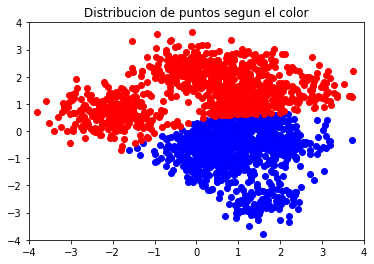

In [30]:
visualize_colors(puntos_azul_train_t, puntos_rojo_train_t)

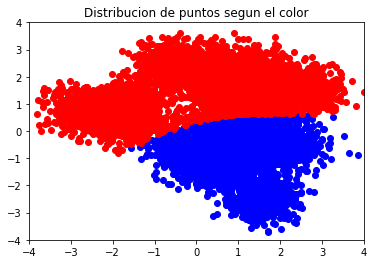

In [31]:
visualize_colors(puntos_azul_test_t, puntos_rojo_test_t)